In [1]:
import pandas as pd
import numpy as np

## Task 1: Understanding the Limitations of RNNs and the Need for Transformers

In [22]:
data = pd.read_csv("/kaggle/input/email-spam-classification/email_spam.csv")
data

,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam
...,...,...,...
79,Your application for the position of Child Pr...,"Dear Maryam, \n\n \n\nI would like to thank yo...",not spam
80,Your Kilimall Account is Ready - Shopping Now!,"Dear Customer,\n\nWelcome to Kilimall, Thanks ...",not spam
81,Your Steam account: Access from new web or mob...,"Dear vladis163rus,\nHere is the Steam Guard co...",not spam
82,Your uploaded document is rejected,View In Browser | Log in\n \n \n\nSkrill logo\...,not spam


In [3]:
# prepare small part of data
spam_samples = data[data['type'] == 'spam'].sample(n=100, random_state=42, replace=True)
ham_samples = data[data['type'] == 'not spam'].sample(n=100, random_state=42, replace=True)

sampled_data = pd.concat([spam_samples, ham_samples]).sample(frac=1, random_state=42).reset_index(drop=True)
sampled_data

,title,text,type
0,Meeting with Walid TOMORROW,"Hello Walid,\n\nOur Zoom call meeting is tomor...",spam
1,English,Sfhdg to iiiiiiuiiiiiiiiiiiii to,spam
2,Hello lun New message from PhebeHotHoney,Adult Dating\n\nDiscover the best site for sin...,spam
3,You've Earned a Reward from Bard Explorers India,You've received a gift!\nSign in to your Bard ...,not spam
4,Re: KPMG 2023 Graduate Recruitment - Aptitude ...,"Dear John,\n\n \n\nThank you for expressing in...",not spam
...,...,...,...
195,"If coding in C++ is so extremely hard, why do ...",TOP STORIES FOR VIRA\n\nQuora\n?\nIf coding in...,not spam
196,Combating scams in the Discogs Marketplace,Discogs has recently detected an increase in s...,spam
197,The Last Call!,"Dear Customer,\n\nAs the tax season comes to a...",spam
198,Your application for the position of Child Pr...,"Dear Maryam, \n\n \n\nI would like to thank yo...",not spam


In [4]:
#tokenize and remove stopwords
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sampled_data['processed_text'] = sampled_data['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### RNN

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sampled_data['processed_text'])
sequences = tokenizer.texts_to_sequences(sampled_data['processed_text'])
word_index = tokenizer.word_index


max_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_length)
y = np.array(sampled_data['type'].map({'not spam': 0, 'spam': 1}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 128, input_length=max_length))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

2025-05-04 11:43:31.759812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746359012.009808      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746359012.080571      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746359025.720796      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746359025.721476      31 gpu_device.cc:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
import time
start = time.time()
model_rnn.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
rnn_time = time.time() - start

loss_rnn, acc_rnn = model_rnn.evaluate(X_test, y_test)
print(f"RNN Accuracy: {acc_rnn:.4f} | Training Time: {rnn_time:.2f} seconds")

Epoch 1/10


I0000 00:00:1746359028.291449      95 service.cc:148] XLA service 0x785288006af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746359028.292243      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746359028.292263      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746359028.731720      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4896 - loss: 0.6992

I0000 00:00:1746359030.013400      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6153 - loss: 0.6276 - val_accuracy: 0.9000 - val_loss: 0.4140
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9689 - loss: 0.2608 - val_accuracy: 0.9000 - val_loss: 0.2676
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9714 - loss: 0.1314 - val_accuracy: 0.9000 - val_loss: 0.2330
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9817 - loss: 0.0971 - val_accuracy: 0.9000 - val_loss: 0.1544
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9852 - loss: 0.0660 - val_accuracy: 0.9250 - val_loss: 0.2062
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9873 - loss: 0.0521 - val_accuracy: 0.9250 - val_loss: 0.1584
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9964 - loss: 0.0279 - val_accuracy: 0.9250 - val_loss: 0.1736
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9794 - loss: 0.0427 - val_accuracy: 0.8750 - val_loss: 0

#### Transformer

In [7]:
sampled_data['label_num'] = sampled_data['type'].map({'spam': 1, 'not spam': 0})
texts = sampled_data['text'].tolist()
labels = sampled_data['label_num'].tolist()
print(labels[:5]) 

[1, 1, 1, 0, 0]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
from transformers import AutoTokenizer

# BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and test texts
train_encodings = tokenizer(
    X_train, truncation=True, padding=True, max_length=128, return_tensors='tf'
)
test_encodings = tokenizer(
    X_test, truncation=True, padding=True, max_length=128, return_tensors='tf'
)

# encoded inputs
X_train_feat = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'token_type_ids': train_encodings['token_type_ids']
}
X_test_feat = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'token_type_ids': test_encodings['token_type_ids']
}

In [14]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=1
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [16]:
start_time = time.time()

history = model.fit(
    X_train_feat, 
    y_train,
    validation_split=0.1,
    epochs=10, 
    batch_size=16
)

end_time = time.time()

tr_time = end_time - start_time
loss_tr, acc_tr = model.evaluate(X_test_feat, y_test)

print(f"Transformer Accuracy: {acc_tr:.4f} | Training Time: {tr_time:.2f} seconds")

Epoch 1/10
9/9 [==============================] - 46s 718ms/step - loss: 0.6954 - accuracy: 0.5208 - val_loss: 0.5801 - val_accuracy: 0.7500
Epoch 2/10
9/9 [==============================] - 4s 435ms/step - loss: 0.7769 - accuracy: 0.4375 - val_loss: 0.6072 - val_accuracy: 0.7500
Epoch 3/10
9/9 [==============================] - 4s 437ms/step - loss: 0.7251 - accuracy: 0.4653 - val_loss: 0.7397 - val_accuracy: 0.7500
Epoch 4/10
9/9 [==============================] - 4s 445ms/step - loss: 0.7029 - accuracy: 0.4931 - val_loss: 0.6108 - val_accuracy: 0.7500
Epoch 5/10
9/9 [==============================] - 4s 454ms/step - loss: 0.7246 - accuracy: 0.4653 - val_loss: 0.8148 - val_accuracy: 0.7500
Epoch 6/10
9/9 [==============================] - 4s 463ms/step - loss: 0.7217 - accuracy: 0.4722 - val_loss: 0.6271 - val_accuracy: 0.7500
Epoch 7/10
9/9 [==============================] - 4s 473ms/step - loss: 0.7111 - accuracy: 0.4861 - val_loss: 0.7654 - val_accuracy: 0.7500
Epoch 8/10
9/9 [===

## Task 2: Self-Attenton Mechanism

Attention weights:
 [[0.398 0.103 0.309 0.083 0.107]
 [0.328 0.135 0.273 0.12  0.143]
 [0.414 0.097 0.299 0.081 0.109]
 [0.283 0.158 0.263 0.141 0.156]
 [0.308 0.146 0.27  0.128 0.148]]

Self-attention output:
 [[0.817 1.004 0.699 1.311]
 [0.792 0.967 0.669 1.256]
 [0.819 1.004 0.707 1.312]
 [0.778 0.95  0.647 1.229]
 [0.786 0.96  0.659 1.245]]


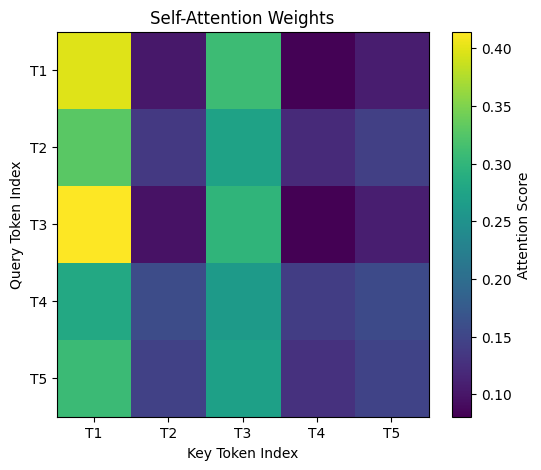

In [17]:
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# toy dataset
np.random.seed(42)
X = np.random.rand(5, 4)

# weight matrices
d_model = X.shape[1]
W_Q = np.random.rand(d_model, d_model)
W_K = np.random.rand(d_model, d_model)
W_V = np.random.rand(d_model, d_model)

Q = X.dot(W_Q)
K = X.dot(W_K)
V = X.dot(W_V)

# attention
d_k = Q.shape[-1]
scores = Q.dot(K.T) / np.sqrt(d_k)
attention_weights = softmax(scores)
output = attention_weights.dot(V)

# results
print("Attention weights:\n", np.round(attention_weights, 3))
print("\nSelf-attention output:\n", np.round(output, 3))

plt.figure(figsize=(6, 5))
plt.imshow(attention_weights, aspect='auto')
plt.title("Self-Attention Weights")
plt.xlabel("Key Token Index")
plt.ylabel("Query Token Index")
plt.colorbar(label="Attention Score")
plt.xticks(range(X.shape[0]), [f"T{i+1}" for i in range(X.shape[0])])
plt.yticks(range(X.shape[0]), [f"T{i+1}" for i in range(X.shape[0])])
plt.show()

## Task 3: Introduction to Transformer Architecture

In [27]:
data = pd.read_csv("/kaggle/input/spam-sms-classification-using-nlp/Spam_SMS.csv")
data

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [37]:
from sklearn.model_selection import train_test_split

# prepare dataset
data['label_bin'] = data['Class'].map({'spam': 1, 'ham': 0})

X_train, X_val, y_train, y_val = train_test_split(data['Message'], data['label_bin'], test_size=0.2, stratify=data['label_bin'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
print("Label distribution in training:", train_df['label_bin'].value_counts().to_dict())
print("Label distribution in validation:", val_df['label_bin'].value_counts().to_dict())

Training samples: 4459, Validation samples: 1115
Label distribution in training: {0: 3861, 1: 598}
Label distribution in validation: {0: 966, 1: 149}


In [30]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# vectorization
max_tokens = 1000 
max_len = 100       
vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len,
                               standardize='lower_and_strip_punctuation', split='whitespace')

vectorizer.adapt(train_df['Message'].values)

sample_text = train_df['Message'].iloc[0]
print("Text:", sample_text)
print("Token sequence:", vectorizer([sample_text]).numpy())

Text: Ok i am on the way to home hi hi
Token sequence: [[ 54   3  61  19   6 128   2  78  97  97   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


In [31]:
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, LayerNormalization, Input, Embedding

# Positional encoding matrix
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]

    angle_rates = 1 / (10000 ** ((2 * (i//2)) / d_model))
    angle_rads = pos * angle_rates

    pos_enc = np.zeros((max_len, d_model))
    pos_enc[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_enc[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return pos_enc

d_model = 64
pos_enc_matrix = positional_encoding(max_len, d_model)
print("Positional encoding shape:", pos_enc_matrix.shape)
print("First 2 position encodings (first 10 dimensions):\n", pos_enc_matrix[:2, :10])

Positional encoding shape: (100, 64)
First 2 position encodings (first 10 dimensions):
 [[0.         1.         0.         1.         0.         1.
  0.         1.         0.         1.        ]
 [0.84147098 0.54030231 0.68156135 0.73176098 0.53316844 0.84600911
  0.40930892 0.91239586 0.31098359 0.95041528]]


In [34]:
from tensorflow.keras.layers import GlobalAveragePooling1D

# Model 
d_model = 64
num_heads = 8
ff_dim = 256 
vocab_size = vectorizer.vocabulary_size()

# input
text_input = Input(shape=(1,), dtype=tf.string, name='email_text')
token_seq = vectorizer(text_input)

# Embedding layer 
embeddings = Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True, name='TokenEmbedding')(token_seq)
# positional encoding
pos_enc = tf.constant(positional_encoding(max_len, d_model), dtype=tf.float32)
embeddings_with_pos = embeddings + pos_enc

# Encoder 1
# Multi-head self-attention
attn_output1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, name='MultiHeadAttn1')(embeddings_with_pos, embeddings_with_pos, embeddings_with_pos)
attn_output1 = Dropout(0.1)(attn_output1)
residual1 = LayerNormalization(epsilon=1e-6)(embeddings_with_pos + attn_output1)
# Feed-forward network
ffn_output1 = Dense(ff_dim, activation='relu')(residual1)
ffn_output1 = Dense(d_model)(ffn_output1)
ffn_output1 = Dropout(0.1)(ffn_output1)
residual2 = LayerNormalization(epsilon=1e-6)(residual1 + ffn_output1)

# Encoder 2 (same as 1)
attn_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, name='MultiHeadAttn2')(residual2, residual2, residual2)
attn_output2 = Dropout(0.1)(attn_output2)
residual3 = LayerNormalization(epsilon=1e-6)(residual2 + attn_output2)
ffn_output2 = Dense(ff_dim, activation='relu')(residual3)
ffn_output2 = Dense(d_model)(ffn_output2)
ffn_output2 = Dropout(0.1)(ffn_output2)
residual4 = LayerNormalization(epsilon=1e-6)(residual3 + ffn_output2)

sequence_avg = GlobalAveragePooling1D(name="AvgPool")(residual4)

# Classification 
output = Dense(1, activation='sigmoid', name='Prediction')(sequence_avg)

In [36]:
from tensorflow.keras.models import Model

model = Model(text_input, output, name="TransformerClassifier")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "TransformerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ email_text (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 100)            │              0 │ email_text[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TokenEmbedding            │ (None, 100, 64)        │         64,000 │ text_vectorization_1[… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 100, 64)        │              0 │ TokenEmbedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MultiHeadAttn1            │ (None, 100, 64)        │         16,640 │ add_5[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_5[0][0],           │
│                           │                        │                │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 100, 64)        │              0 │ MultiHeadAttn1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 100, 64)        │              0 │ add_5[0][0],           │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 100, 64)        │            128 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 100, 256)       │         16,640 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 100, 64)        │         16,448 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 100, 64)        │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 100, 64)        │              0 │ layer_normalization_4… │
│                           │                        │                │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 100, 64)        │            128 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MultiHeadAttn2            │ (None, 100, 64)        │         16,640 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
│                           │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout) 

 Total params: 164,033 (640.75 KB)

 Trainable params: 164,033 (640.75 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16)

Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8592 - loss: 0.4062 - val_accuracy: 0.9668 - val_loss: 0.1062
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9684 - loss: 0.1039 - val_accuracy: 0.9776 - val_loss: 0.0760
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9812 - loss: 0.0618 - val_accuracy: 0.9803 - val_loss: 0.0654
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9844 - loss: 0.0475 - val_accuracy: 0.9857 - val_loss: 0.0520
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9933 - loss: 0.0237 - val_accuracy: 0.9803 - val_loss: 0.0684


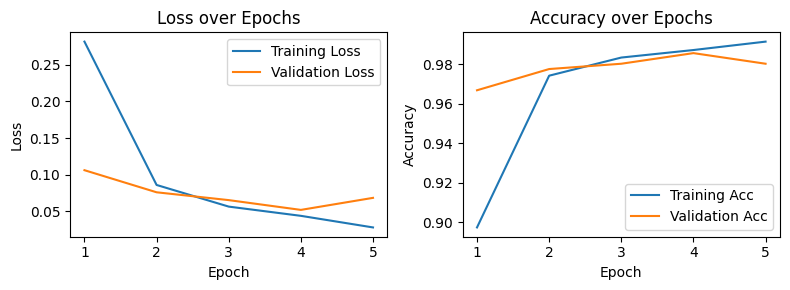

In [39]:
history_dict = history.history
epochs = range(1, len(history_dict['loss'])+1)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_dict['accuracy'], label='Training Acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Task 4: Pretrained Language Models (BERT, GPT, T5)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(data['Message'], data['label_bin'], test_size=0.2, stratify=data['label_bin'], random_state=42)


y_train = np.array(y_train)
y_test = np.array(y_test)

In [61]:
from transformers import AutoTokenizer

# BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_texts = X_train.tolist()
test_texts  = X_test.tolist()

# now tokenize
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# build feature dicts
X_train_feat = {
    'input_ids':      train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'token_type_ids': train_encodings.get('token_type_ids')  # BERT models only
}
X_test_feat = {
    'input_ids':      test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'token_type_ids': test_encodings.get('token_type_ids')
}


In [66]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=1
)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
history = model.fit(
    X_train_feat, 
    y_train,
    validation_split=0.1,
    epochs=10, 
    batch_size=16
)

loss_tr, acc_tr = model.evaluate(X_test_feat, y_test)

print(f"BERT Accuracy: {acc_tr:.4f}")

Epoch 1/10
251/251 [==============================] - 162s 454ms/step - loss: 0.4119 - accuracy: 0.8622 - val_loss: 0.4671 - val_accuracy: 0.8453
Epoch 2/10
251/251 [==============================] - 109s 435ms/step - loss: 0.3966 - accuracy: 0.8682 - val_loss: 0.4601 - val_accuracy: 0.8453
Epoch 3/10
251/251 [==============================] - 109s 433ms/step - loss: 0.3983 - accuracy: 0.8682 - val_loss: 0.4587 - val_accuracy: 0.8453
Epoch 4/10
251/251 [==============================] - 109s 434ms/step - loss: 0.3961 - accuracy: 0.8682 - val_loss: 0.4398 - val_accuracy: 0.8453
Epoch 5/10
251/251 [==============================] - 109s 434ms/step - loss: 0.3967 - accuracy: 0.8682 - val_loss: 0.4433 - val_accuracy: 0.8453
Epoch 6/10
251/251 [==============================] - 109s 434ms/step - loss: 0.3939 - accuracy: 0.8682 - val_loss: 0.4385 - val_accuracy: 0.8453
Epoch 7/10
251/251 [==============================] - 109s 434ms/step - loss: 0.3944 - accuracy: 0.8682 - val_loss: 0.4377 -

In [82]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# settings for model
MODEL_NAME = "bert-base-uncased"
MAX_LEN    = 64
BATCH_SIZE = 32
EPOCHS     = 3
LR         = 2e-5

In [83]:
raw_ds = load_dataset("imdb")  # splits: 'train', 'test'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def fast_encode(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

tokenized_train = raw_ds["train"].map(fast_encode, batched=True, remove_columns=["text"])
tokenized_test  = raw_ds["test"].map (fast_encode, batched=True, remove_columns=["text"])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [84]:
train_ds = tokenized_train.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=BATCH_SIZE
).cache().prefetch(tf.data.AUTOTUNE)

test_ds = tokenized_test.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=BATCH_SIZE
).prefetch(tf.data.AUTOTUNE)

In [91]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1  # single logit
)

model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
try:
    model.optimizer.learning_rate.assign(2e-5)
except AttributeError:
    model.optimizer.lr.assign(2e-5)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3
)

print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/3
782/782 [==============================] - 511s 593ms/step - loss: 0.6328 - accuracy: 0.6784 - val_loss: 0.6861 - val_accuracy: 0.6185
Epoch 2/3
782/782 [==============================] - 459s 587ms/step - loss: 0.6603 - accuracy: 0.6120 - val_loss: 0.6799 - val_accuracy: 0.5091
Epoch 3/3
782/782 [==============================] - 458s 586ms/step - loss: 0.5708 - accuracy: 0.7006 - val_loss: 0.5459 - val_accuracy: 0.8059
Final validation accuracy: 0.8058800101280212


#### Text Generation

In [93]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForCausalLM
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

MODEL_NAME   = "distilgpt2"     # lighter than gpt2
SEQ_LEN      = 64               # shorter sequence length
BATCH_SIZE   = 8                # adjust to fit GPU

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
model = TFAutoModelForCausalLM.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [100]:
path = "/kaggle/input/shakespeare-text/text.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read()

tokens = tokenizer(text, return_tensors="tf", add_special_tokens=False)["input_ids"][0]

all_sequences = tf.data.Dataset.from_tensor_slices(tokens)
sequences = all_sequences.batch(SEQ_LEN + 1, drop_remainder=True)

def split_input_labels(batch):
    input_seq = batch[:-1]
    label_seq = batch[1:]
    return {"input_ids": input_seq}, label_seq

dataset = sequences.map(split_input_labels, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)
try:
    model.optimizer.learning_rate.assign(2e-5)
except AttributeError:
    model.optimizer.lr.assign(2e-5)
    
model.fit(dataset, epochs=5)

model.save_pretrained("/kaggle/working/distilgpt2-shakespeare")
tokenizer.save_pretrained("/kaggle/working/distilgpt2-shakespeare")

Epoch 1/5
650/650 [==============================] - 110s 140ms/step - loss: 3.7770
Epoch 2/5
650/650 [==============================] - 93s 142ms/step - loss: 3.6580
Epoch 3/5
650/650 [==============================] - 93s 142ms/step - loss: 3.5789
Epoch 4/5
650/650 [==============================] - 93s 142ms/step - loss: 3.5126
Epoch 5/5
650/650 [==============================] - 93s 142ms/step - loss: 3.4513


('/kaggle/working/distilgpt2-shakespeare/tokenizer_config.json',
 '/kaggle/working/distilgpt2-shakespeare/special_tokens_map.json',
 '/kaggle/working/distilgpt2-shakespeare/vocab.json',
 '/kaggle/working/distilgpt2-shakespeare/merges.txt',
 '/kaggle/working/distilgpt2-shakespeare/added_tokens.json',
 '/kaggle/working/distilgpt2-shakespeare/tokenizer.json')

In [101]:
prompt = "To be, or not to be, "
input_ids = tokenizer(prompt, return_tensors="tf").input_ids
gen = model.generate(input_ids, max_length=SEQ_LEN, do_sample=True, top_k=50, top_p=0.95)
print(tokenizer.decode(gen[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


To be, or not to be, urchon'd, at liberty or to be,
And not so much to be?

First Senator:
A good cause, gentlemen.

AUTOLYCUS:
Well, well, my lord; if this be so, I'll hear from you


#### T5

## Task 5: Named Entity Recognition (NER) and Part-of-Speech (POS) Tagging

In [114]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import glob, re

files = glob.glob("/kaggle/input/shakespeare-text/text.txt", recursive=True)
path = files[0]

with open(path, "r", encoding="utf-8") as f:
    text = f.read()
sentences = re.split(r'(?<=[\.\?\!])\s+', text)

model   = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

for i, sent in enumerate(sentences[:5], 1):
    input_text = f"translate English to German: {sent}"
    input_ids  = tokenizer(input_text, return_tensors="pt", truncation=True, padding="longest", max_length=256).input_ids
    outputs    = model.generate(input_ids, max_length=256, num_beams=4, early_stopping=True)
    german    = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"{i}. {german}\n")


1. Erster Bürger: Bevor wir weitermachen, hören Sie mir das Wort.

2. Alle: Sprechen, sprechen.

3. Erster Bürger: Sie alle sind eher entschlossen, zu sterben als zu famieren?

4. Alles: gelöst.

5. gelöst.



In [117]:
df = pd.read_csv(
    '/kaggle/input/news-articles/Articles.csv',
    encoding='latin1',
    engine='python', 
)
print(df.head())

                                             Article      Date  \
0  KARACHI: The Sindh government has decided to b...  1/1/2015   
1  HONG KONG: Asian markets started 2015 on an up...  1/2/2015   
2  HONG KONG:  Hong Kong shares opened 0.66 perce...  1/5/2015   
3  HONG KONG: Asian markets tumbled Tuesday follo...  1/6/2015   
4  NEW YORK: US oil prices Monday slipped below $...  1/6/2015   

                                             Heading  NewsType  
0  sindh govt decides to cut public transport far...  business  
1                    asia stocks up in new year trad  business  
2           hong kong stocks open 0.66 percent lower  business  
3             asian stocks sink euro near nine year   business  
4                 us oil prices slip below 50 a barr  business  


In [119]:
import spacy
from transformers import pipeline

# spaCy
nlp = spacy.load('en_core_web_sm')

def spacy_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def spacy_pos(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

df['spacy_ents'] = df['Article'].apply(spacy_ner)
df['spacy_pos']  = df['Article'].apply(spacy_pos)


In [123]:
from transformers import pipeline

# Transformer-based
ner_pipeline = pipeline(
    'ner',
    model='dslim/bert-base-NER',
    tokenizer='bert-base-cased',
    aggregation_strategy='simple',
    device=-1
)

df['bert_ents'] = df['Article'].apply(lambda t: ner_pipeline(t))
df['spacy_pos']  = df['Article'].apply(lambda t: [(token.text, token.pos_) for token in nlp(t)])

print(df[['bert_ents', 'spacy_pos']].head())

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


                                           bert_ents  \
0  [{'entity_group': 'ORG', 'score': 0.9342551, '...   
1  [{'entity_group': 'LOC', 'score': 0.97484744, ...   
2  [{'entity_group': 'LOC', 'score': 0.5216299, '...   
3  [{'entity_group': 'LOC', 'score': 0.57868624, ...   
4  [{'entity_group': 'LOC', 'score': 0.4661209, '...   

                                           spacy_pos  
0  [(KARACHI, PROPN), (:, PUNCT), (The, DET), (Si...  
1  [(HONG, PROPN), (KONG, PROPN), (:, PUNCT), (As...  
2  [(HONG, PROPN), (KONG, PROPN), (:, PUNCT), ( ,...  
3  [(HONG, PROPN), (KONG, PROPN), (:, PUNCT), (As...  
4  [(NEW, PROPN), (YORK, PROPN), (:, PUNCT), (US,...  


## Task 7: Sentiment Analysis with Transformers


In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    create_optimizer
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Data
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train","test"],
    as_supervised=True,
    with_info=True
)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model     = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

def encode(text, label):
    txt = text.numpy().decode("utf-8")
    toks = tokenizer(txt,
                    truncation=True,
                    padding="max_length",
                    max_length=64,
                    return_tensors="np")
    return toks["input_ids"][0], toks["attention_mask"][0], label

def tf_encode(text, label):
    in_ids, attn, lbl = tf.py_function(
        func=encode,
        inp=[text, label],
        Tout=[tf.int32, tf.int32, tf.int64]
    )
    in_ids.set_shape([64])
    attn.set_shape([64])
    lbl.set_shape([])
    return {"input_ids": in_ids, "attention_mask": attn, "labels": lbl}

batch_size = 32

train_ds = (
    ds_train
      .map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
      .shuffle(10_000)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    ds_test
      .map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

num_steps = (ds_info.splits["train"].num_examples // batch_size) * 3
opt, _ = create_optimizer(2e-5, num_warmup_steps=0, num_train_steps=num_steps)

model.compile(optimizer=opt, metrics=["accuracy"])

model.fit(train_ds, epochs=3)

y_true, y_pred = [], []
for batch in test_ds:
    inputs = {k: v for k,v in batch.items() if k!="labels"}
    labels = batch["labels"].numpy()
    logits = model(inputs, training=False).logits
    preds = tf.argmax(logits, axis=-1).numpy()
    y_true.append(labels); y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("Acc:", accuracy_score(y_true, y_pred))
print("F1: ", f1_score(y_true, y_pred))
print("CM:\n", confusion_matrix(y_true, y_pred))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
782/782 [==============================] - 205s 222ms/step - loss: 0.4357 - accuracy: 0.7901
Epoch 2/3
782/782 [==============================] - 183s 223ms/step - loss: 0.3043 - accuracy: 0.8708
Epoch 3/3
782/782 [==============================] - 183s 223ms/step - loss: 0.2090 - accuracy: 0.9187
Acc: 0.82292
F1:  0.825660615130154
CM:
 [[10090  2410]
 [ 2017 10483]]


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

max_words = 20000
max_len   = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(
    tokenizer.texts_to_sequences(train_texts),
    maxlen=max_len
)
X_test  = pad_sequences(
    tokenizer.texts_to_sequences(test_texts),
    maxlen=max_len
)

model_lstm = Sequential([
    Embedding(input_dim=max_words+1,  # <-- allow index 20000
              output_dim=128),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model_lstm.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_lstm.fit(
    X_train, np.array(train_labels),
    epochs=5, batch_size=64,
    validation_split=0.1
)


Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6903 - loss: 0.5523 - val_accuracy: 0.8560 - val_loss: 0.3410
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8777 - loss: 0.3096 - val_accuracy: 0.8584 - val_loss: 0.3274
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9152 - loss: 0.2223 - val_accuracy: 0.8584 - val_loss: 0.3416
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9254 - loss: 0.1960 - val_accuracy: 0.8576 - val_loss: 0.3700
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9381 - loss: 0.1563 - val_accuracy: 0.8616 - val_loss: 0.3856


In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

lstm_preds = (model_lstm.predict(X_test) > 0.5).astype(int).flatten()

acc_lstm = accuracy_score(test_labels, lstm_preds)
f1_lstm  = f1_score(test_labels, lstm_preds)
cm_lstm  = confusion_matrix(test_labels, lstm_preds)

print("LSTM Accuracy:", acc_lstm)
print("LSTM F1-Score:", f1_lstm)
print("LSTM Confusion Matrix:\n", cm_lstm)


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
LSTM Accuracy: 0.85344
LSTM F1-Score: 0.8504855953644004
LSTM Confusion Matrix:
 [[10915  1585]
 [ 2079 10421]]
